# 🖼️ Getting Started

Welcome to Composer! If you're wondering how this thing works, then you're in the right place. This is the first in our series of tutorials aimed at getting you familiar with the core concepts, capabilities, and patterns that make Composer such a useful tool!

### Recommended Background

For the sake of this tutorial, we won't assume you know much about Composer, but a quick read of the [Welcome Tour][welcome_tour] wouldn't hurt.

Composer is heavily built around PyTorch, though, so we will assume some basic familiarity with it. If you're unfamiliar with PyTorch, we recommend spending some time getting used to its [basics][pytorch_basics].

### Tutorial Goals and Concepts Covered

We're going to focus this introduction to Composer around an old classic: training a ResNet56 model on CIFAR10.

Our focus here running this with the [Composer Trainer][trainer].

As part of using the Trainer, we'll set up:

* [Dataloaders](#Dataset-and-DataLoader)
* [A ResNet56 model](#Model)
* [An optimizer and learning rate scheduler](#Optimizer-and-Scheduler)
* [A logger](#Logging)

We'll show how to [assemble these pieces and train with the Trainer](#Train-a-Baseline-Model)

And finally we'll demonstrate [training with speed-up algorithms!](#Use-Algorithms-to-Speed-Up-Training)

Along the way we'll illustrate some ways to visualize training progress using loggers.

Let's get started!


[welcome_tour]: https://docs.mosaicml.com/projects/composer/en/stable/getting_started/welcome_tour.html
[pytorch_basics]: https://pytorch.org/tutorials/beginner/basics/intro.html
[trainer]: https://docs.mosaicml.com/projects/composer/en/stable/api_reference/generated/composer.Trainer.html#trainer

## Install Composer

We'll start by installing Composer

In [11]:
%pip install --upgrade composer==0.14.1
# To install from source instead of the last release, comment the command above and uncomment the following one.
# %pip install git+https://github.com/mosaicml/composer.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.9/565.9 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 790.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Set Up Our Workspace

### Imports

In this section we'll set up our workspace. We'll import the necessary packages, and set up our dataset and trainer. First, the imports:

In [1]:
import time

import torch
import torch.utils.data

import composer
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from composer.loggers import InMemoryLogger

torch.manual_seed(42) # For replicability

Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1


### Dataset and DataLoader
<a id="Dataset-&-DataLoader"></a>

Now we'll start setting up the ingredients for the Composer Trainer! Let's start with dataloaders...

Here, we instantiate our CIFAR-10 dataset and dataloader. Composer has its own CIFAR-10 dataset and dataloaders for convenience, but we'll stick with the Torchvision CIFAR-10 and PyTorch dataloader for the sake of familiarity.

As a bit of extra detail, there are [three ways][composer_dataloaders] of passing training and/or evaluation dataloaders to the Trainer. If you're used to working with [PyTorch dataloaders][pytorch_dataloaders], good news—that's one of the ways! The below code should look pretty familiar if you're coming from PyTorch, but if not, now may be a good time to familiarize yourself with those basics.

[composer_dataloaders]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/dataloaders.html
[pytorch_dataloaders]: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [2]:
data_directory = "./data"

# Normalization constants
mean = (0.507, 0.487, 0.441)
std = (0.267, 0.256, 0.276)

batch_size = 1024

cifar10_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

train_dataset = datasets.CIFAR10(data_directory, train=True, download=True, transform=cifar10_transforms)
test_dataset = datasets.CIFAR10(data_directory, train=False, download=True, transform=cifar10_transforms)

# Our train and test dataloaders are PyTorch DataLoader objects!
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Model
<a id="Model"></a>

Next, we create our model. We're using Composer's built-in ResNet56. To use your own custom model, please see this [custom model example][custom_model_example].

**Note**: The model below is an instance of a [ComposerModel][composer_model]. Models need to be wrapped in this class, which provides a convenient interface between the underlying PyTorch model and the Trainer.

[custom_model_example]: https://docs.mosaicml.com/projects/composer/en/stable/composer_model.html#using-your-own-model
[composer_model]: https://docs.mosaicml.com/projects/composer/en/stable/api_reference/generated/composer.ComposerModel.html#composer.ComposerModel

In [3]:
from composer import models

model = models.composer_resnet_cifar(model_name='resnet_56', num_classes=10)

### Optimizer and Scheduler
<a id="Optimizer-and-Scheduler"></a>

Now let's create the optimizer and LR scheduler. We're using [MosaicML's SGD with decoupled weight decay][weight_decay]:

[weight_decay]: https://arxiv.org/abs/1711.05101

In [4]:
optimizer = composer.optim.DecoupledSGDW(
    model.parameters(), # Model parameters to update
    lr=0.05, # Peak learning rate
    momentum=0.9,
    weight_decay=2.0e-3 # If this looks large, it's because its not scaled by the LR as in non-decoupled weight decay
)

We'll assume this is being run on Colab, which means training for hundreds of epochs would take a very long time. Instead we'll train our baseline model for three epochs. The first epoch will be linear warmup, followed by two epochs of constant LR. We achieve this by instantiating a `LinearWithWarmupScheduler` class.

**Note**: Composer provides a handful of different [schedulers][schedulers] to help customize your training!

[schedulers]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/schedulers.html

In [5]:
lr_scheduler = composer.optim.LinearWithWarmupScheduler(
    t_warmup="1ep", # Warm up over 1 epoch
    alpha_i=1.0, # Flat LR schedule achieved by having alpha_i == alpha_f
    alpha_f=1.0
)

### Logging
<a id="Logging"></a>

Finally, we instantiate an [InMemoryLogger][in_memory_logger] that records all the data from the Composer Trainer. We will use this logger to generate data plots after we complete training.

[in_memory_logger]: https://docs.mosaicml.com/projects/composer/en/stable/api_reference/generated/composer.loggers.InMemoryLogger.html

In [6]:
# "baseline" = no algorithms (which is what we're doing now)
logger_for_baseline = InMemoryLogger()

## Train a Baseline Model
<a id="Train-a-Baseline-Model"></a>

And now we create our trainer!

**The Trainer class is the workhorse of Composer.** You may be wondering what exactly it does. In short, the `Trainer` class takes a handful of ingredients (e.g., the model, data loaders, algorithms) and instructions (e.g., training duration, device) and *composes* them into a single object (here, `trainer`) that can manage **the entire training loop** described by those inputs. This lets you focus on the higher-level details of training without having to worry about things like distributed training, scheduling, memory issues, and all other kinds of low-level headaches.

If you want to learn more about the Trainer, we recommend a deeper dive through our [docs][trainer_docs] and the [API reference][api]! In the meantime, you can follow the patterns in this tutorial to get going quickly.

Here's a quick reference for the parameters we're specifying below:

-   `model`: The model to train, an instance of [ComposerModel][composer_model] (in this case a ResNet-56)
-   `train_dataloader`: A data loader supplying the training data. More info [here][dataloaders].
-   `eval_dataloader`: A data loader supplying the data used during evaluation (see same reference for `train_dataloader`). Model-defined evaluation metrics will be aggregated across this dataset each evaluation round.
-   `max_duration`: The training duration. You can use integers to specify the number of epochs or provide a [Time][time] string -- e.g., `"50ba"` or `"2ep"` for 50 batches and 2 epochs, respectively.
-   `optimizer`: The optimizer used to update the model during training. More info [here][optimizers].
-   `schedulers`: Any schedulers used to schedule hyperparameter (e.g., learning rate) values over the course of training. More info [here][schedulers].
-   `device`: The device to use (e.g., CPU or GPU).
-   `loggers`: Any loggers to use during training. More info [here][loggers].


[trainer_docs]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/using_the_trainer.html
[api]: https://docs.mosaicml.com/projects/composer/en/stable/api_reference/generated/composer.Trainer.html#trainer
[composer_model]: https://docs.mosaicml.com/projects/composer/en/stable/composer_model.html
[dataloaders]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/dataloaders.html
[time]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/time.html
[optimizers]: https://docs.mosaicml.com/projects/composer/en/stable/api_reference/composer.optim.html
[schedulers]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/schedulers.html
[loggers]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/logging.html


In [7]:
train_epochs = "3ep" # Train for 3 epochs because we're assuming Colab environment and hardware
device = "gpu" if torch.cuda.is_available() else "cpu" # select the device

trainer = composer.trainer.Trainer(
    model=model,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    max_duration=train_epochs,
    optimizers=optimizer,
    schedulers=lr_scheduler,
    device=device,
    loggers=logger_for_baseline,
)

We train and measure the training time below.

In [8]:
start_time = time.perf_counter()
trainer.fit() # <-- Your training loop in action!
end_time = time.perf_counter()
print(f"It took {end_time - start_time:0.4f} seconds to train")

******************************
Config:
node_name: unknown because NODENAME environment variable not set
num_gpus_per_node: 1
num_nodes: 1
rank_zero_seed: 3962047331

******************************


train          Epoch   0:    0%|| 0/49 [00:00<?, ?ba/s]         

/usr/local/lib/python3.11/dist-packages/composer/core/data_spec.py:39: UserWarning: Cannot split tensor of length 848 into batches of size 1024. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


eval           Epoch   0:    0%|| 0/10 [00:00<?, ?ba/s]         

/usr/local/lib/python3.11/dist-packages/composer/core/data_spec.py:39: UserWarning: Cannot split tensor of length 784 into batches of size 1024. As it is smaller, no splitting will be done. This may happen on the last batch of a dataset if it is a smaller size than the microbatch size.
  warnings.warn(f'Cannot split tensor of length {len(t)} into batches of size {microbatch_size}. '


train          Epoch   1:    0%|| 0/49 [00:00<?, ?ba/s]         

eval           Epoch   1:    0%|| 0/10 [00:00<?, ?ba/s]         

train          Epoch   2:    0%|| 0/49 [00:00<?, ?ba/s]         

eval           Epoch   2:    0%|| 0/10 [00:00<?, ?ba/s]         

It took 105.7684 seconds to train


If you're running this on Colab, the runtime will vary a lot based on the instance. We found that the three epochs of training could take anywhere from 120-550 seconds to run, and the mean validation accuracy was typically in the range of 25%-40%.

### Extract and Plot Logged Data

We can now plot our validation accuracy over training...

Now, you might be thinking, "I don't remember logging any validation accuracy!" And you'd be right—sort of. That's because all the logging happened automatically during the `trainer.fit()` call. The values that we'll plot were set up by the model, which defines which metric(s) to measure during evaluation (and possibly also during training). Check out the [documentation][loggers] for a deeper dive on the loggers Composer offers and how to interact with them!

[loggers]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/logging.html

In [17]:
logger_for_baseline.data.keys()

dict_keys(['time/epoch', 'time/batch', 'time/sample', 'time/batch_in_epoch', 'time/sample_in_epoch', 'trainer/device_train_microbatch_size', 'loss/train/total', 'metrics/train/MulticlassAccuracy', 'metrics/eval/CrossEntropy', 'metrics/eval/MulticlassAccuracy'])

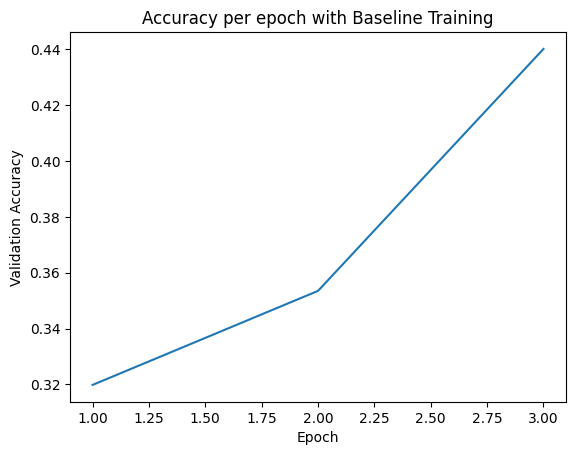

In [16]:
# metric_name = "metrics/eval/CrossEntropy"
metric_name = "metrics/eval/MulticlassAccuracy"
timeseries_raw = logger_for_baseline.get_timeseries(metric_name)
plt.plot(timeseries_raw['epoch'], timeseries_raw[metric_name])
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy per epoch with Baseline Training")
plt.show()

## Use Algorithms to Speed Up Training
<a id="Use-Algorithms-to-Speed-Up-Training"></a>

One of the things we're most excited about at MosaicML is our arsenal of speed-up [algorithms][algorithms]. We used these algorithms to [speed up training of ResNet-50 on ImageNet by up to 7.6x][explorer]. Let's try applying a few algorithms to make our ResNet-56 more efficient.

Before we jump in, here's a quick primer on Composer speed-up algorithms. Each one is implemented as an `Algorithm` class, which basically just adds some structure that controls what happens when the algorithm is applied and when in the training loop it should be applied. Adding a particular algorithm into the training loop is as simple as creating an instance of it (using args/kwargs to set any hyperparameters) and passing it to the `Trainer` during initialization. We'll see that in action below...

For our first algorithm here, let's start with [Label Smoothing][label_smoothing], which serves as a form of regularization by interpolating between the target distribution and another distribution that usually has higher entropy.

[algorithms]: https://docs.mosaicml.com/projects/composer/en/stable/trainer/algorithms.html
[explorer]: https://app.mosaicml.com/explorer/imagenet
[label_smoothing]: https://docs.mosaicml.com/projects/composer/en/stable/method_cards/label_smoothing.html

In [ ]:
label_smoothing = composer.algorithms.LabelSmoothing(0.1) # We're creating an instance of the LabelSmoothing algorithm class

Let's also use [BlurPool][blurpool], which increases accuracy by applying a spatial low-pass filter before the pool in max pooling and whenever using a strided convolution.

[blurpool]: https://docs.mosaicml.com/projects/composer/en/stable/method_cards/blurpool.html

In [ ]:
blurpool = composer.algorithms.BlurPool(
    replace_convs=True, # Blur before convs
    replace_maxpools=True, # Blur before max-pools
    blur_first=True # Blur before conv/max-pool
)

Our final algorithm in our improved training recipe is [Progressive Image Resizing][progressive_image_resizing]. Progressive Image Resizing initially shrinks the size of training images and slowly scales them back to their full size over the course of training. It increases throughput during the early phase of training, when the network may learn coarse-grained features that do not require the details lost by reducing image resolution.

[progressive_image_resizing]: https://docs.mosaicml.com/projects/composer/en/stable/method_cards/progressive_resizing.html

In [ ]:
prog_resize = composer.algorithms.ProgressiveResizing(
    initial_scale=.6, # Size of images at the beginning of training = .6 * default image size
    finetune_fraction=0.34, # Train on default size images for 0.34 of total training time.
)

We'll assemble all our algorithms into a list to pass to our trainer.

In [ ]:
algorithms = [label_smoothing, blurpool, prog_resize]

Now let's instantiate our model, optimizer, logger, and trainer again. No need to instantiate our scheduler again because it's stateless!

In [ ]:
model = models.composer_resnet_cifar(model_name="resnet_56", num_classes=10)

logger_for_algorithm_run = InMemoryLogger()

optimizer = composer.optim.DecoupledSGDW(
    model.parameters(),
    lr=0.05,
    momentum=0.9,
    weight_decay=2.0e-3
)

trainer = composer.trainer.Trainer(
    model=model,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    max_duration=train_epochs,
    optimizers=optimizer,
    schedulers=lr_scheduler,
    device=device,
    loggers=logger_for_algorithm_run,
    algorithms=algorithms # Adding algorithms this time!
)

And let's get training!

In [ ]:
# Now we're cooking with algorithms!
start_time = time.perf_counter()
trainer.fit()
end_time = time.perf_counter()
three_epochs_accelerated_time = end_time - start_time
print(f"It took {three_epochs_accelerated_time:0.4f} seconds to train")

Again, the runtime will vary based on the instance, but we found that it took about **0.43x-0.75x** as long to train (a **1.3x-2.3x** speedup, which corresponds to 90-400 seconds) relative to the baseline recipe without augmentations. We also found that validation accuracy was similar for the algorithm-enhanced and baseline recipes.

### Bonus Training!

Because Progressive Resizing increases data throughput (i.e. more samples per second), we can train for more iterations in the same amount of wall clock time. Let's train our model for one additional epoch!

In [ ]:
train_epochs = "1ep"

Resuming training means we'll need to use a flat LR schedule:

In [ ]:
lr_scheduler = composer.optim.scheduler.ConstantScheduler(alpha=1.0, t_max='1dur')

And we can also get rid of progressive resizing (because we want to train on the full size images for this additional epoch), and the model already has blurpool enabled, so we don't need to pass that either:

In [ ]:
algorithms = [label_smoothing]

In [ ]:
logger_for_bonus_1ep = InMemoryLogger()

trainer = composer.trainer.Trainer(
    model=model,
    train_dataloader=train_dataloader,
    eval_dataloader=test_dataloader,
    max_duration=train_epochs,
    optimizers=optimizer,
    schedulers=lr_scheduler,
    device=device,
    loggers=logger_for_bonus_1ep,
    algorithms=algorithms,
)

start_time = time.perf_counter()
trainer.fit()

end_time = time.perf_counter()
final_epoch_accelerated_time = end_time - start_time
# Time for four epochs = time for three epochs + time for fourth epoch
four_epochs_accelerated_time = three_epochs_accelerated_time + final_epoch_accelerated_time
print(f"It took {four_epochs_accelerated_time:0.4f} seconds to train")

We found that using these speed-up algorithms for four epochs resulted in runtime similar to or less than three epochs *without* speed-up algorithms (120-550 seconds, depending on the instance), and that they usually improved validation accuracy by 5-15 percentage points, yielding validation accuracy in the range of 30%-50%.

Let's plot the results from using Label Smoothing and Progressive Resizing!

In [ ]:
# Baseline (no algorithms) data
baseline_timeseries = logger_for_baseline.get_timeseries("metrics/eval/MulticlassAccuracy")
baseline_epochs = baseline_timeseries['epoch']
baseline_acc = baseline_timeseries["metrics/eval/MulticlassAccuracy"]

# Composer data
with_algorithms_timeseries = logger_for_algorithm_run.get_timeseries("metrics/eval/MulticlassAccuracy")
with_algorithms_epochs = list(with_algorithms_timeseries["epoch"])
with_algorithms_acc = list(with_algorithms_timeseries["metrics/eval/MulticlassAccuracy"])

# Concatenate 3 epochs with Label Smoothing and ProgRes with 1 epoch without ProgRes
bonus_epoch_timeseries = logger_for_bonus_1ep.get_timeseries("metrics/eval/MulticlassAccuracy")
bonus_epoch_epochs = [with_algorithms_epochs[-1] + i for i in bonus_epoch_timeseries["epoch"]]
with_algorithms_epochs.extend(bonus_epoch_epochs)
with_algorithms_acc.extend(bonus_epoch_timeseries["metrics/eval/MulticlassAccuracy"])

#Print mean validation accuracies
print("Baseline Validation Mean: " + str(sum(baseline_acc)/len(baseline_acc)))
print("W/ Algs. Validation Mean: " + str(sum(with_algorithms_acc)/len(with_algorithms_acc)))

# Plot both sets of data
plt.plot(baseline_epochs, baseline_acc, label="Baseline")
plt.plot(with_algorithms_epochs, with_algorithms_acc, label="With Algorithms")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy and speed improvements with equivalent WCT")
plt.show()


## What next?

You've now seen a simple example of how to use the Composer Trainer and how to take advantage of useful features like learning rate scheduling, logging, and speed-up algorithms.

If you want to keep learning more, try looking through some of the documents linked throughout this tutorial to see if you can form a deeper intuition for how these examples were structured.

In addition, please continue to explore our tutorials! Here's a couple suggestions:

* Get to know the [functional API][functional_tutorial] for using algorithms outside the Trainer.

* Explore more advanced applications of Composer like [applying image segmentation to medical images][image_segmentation_tutorial] or [fine-tuning a transformer for sentiment classification][huggingface_tutorial].

* Learn about callbacks and how to apply [early stopping][early_stopping_tutorial].

[functional_tutorial]: https://docs.mosaicml.com/projects/composer/en/stable/examples/functional_api.html
[image_segmentation_tutorial]: https://docs.mosaicml.com/projects/composer/en/stable/examples/medical_image_segmentation.html
[huggingface_tutorial]: https://docs.mosaicml.com/projects/composer/en/stable/examples/huggingface_models.html
[early_stopping_tutorial]: https://docs.mosaicml.com/projects/composer/en/stable/examples/early_stopping.html

## Come get involved with MosaicML!

We'd love for you to get involved with the MosaicML community in any of these ways:

### [Star Composer on GitHub](https://github.com/mosaicml/composer)

Help make others aware of our work by [starring Composer on GitHub](https://github.com/mosaicml/composer).

### [Join the MosaicML Slack](https://join.slack.com/t/mosaicml-community/shared_invite/zt-w0tiddn9-WGTlRpfjcO9J5jyrMub1dg)

Head on over to the [MosaicML slack](https://join.slack.com/t/mosaicml-community/shared_invite/zt-w0tiddn9-WGTlRpfjcO9J5jyrMub1dg) to join other ML efficiency enthusiasts. Come for the paper discussions, stay for the memes!

### Contribute to Composer

Is there a bug you noticed or a feature you'd like? File an [issue](https://github.com/mosaicml/composer/issues) or make a [pull request](https://github.com/mosaicml/composer/pulls)!